#### Time Series Forecasting: Stock Prices

In [1]:
from helper_funcs import *
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('data/accenture', index_col=['Date'], parse_dates=['Date'])

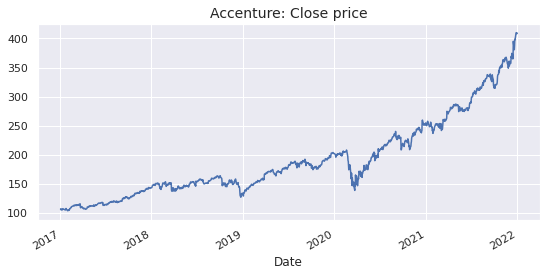

In [3]:
df.Close.plot(figsize=(9, 4))
plt.title("Accenture: Close price", fontsize=14)
plt.show()

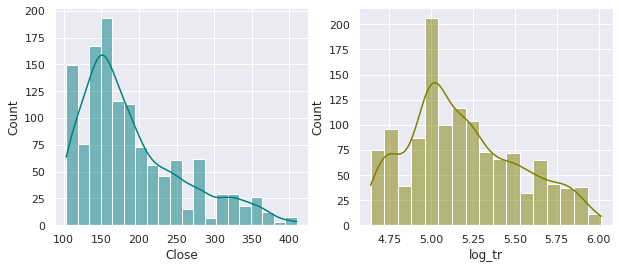

In [4]:
# Log transformation
df['log_tr'] = np.log(df['Close'])

fig, axs = plt.subplots(1,2, figsize=(10, 4))
sns.histplot(df.Close, kde=True, color="teal", ax=axs[0])
sns.histplot(df.log_tr, kde=True, color="olive", ax=axs[1])
plt.show()

After making the time series stationary in the 1st task, it can be inferred that there's no seasonal behaviour.<br>
Thus, a seasonal term is not needed. The model selected is ARIMA.

In [5]:
obtain_adf_kpss_results(df.log_tr, 3)

,d,adf_stats,p-value (kpss),is_adf_stationary,is_kpss_stationary,is_stationary
0,0,9.803014e-01,0.01,False,False,False
1,1,2.306661e-18,0.10,True,True,True
2,2,6.452348e-24,0.10,True,True,True


Applying differentiation once makes the time series stationary: `d=1`

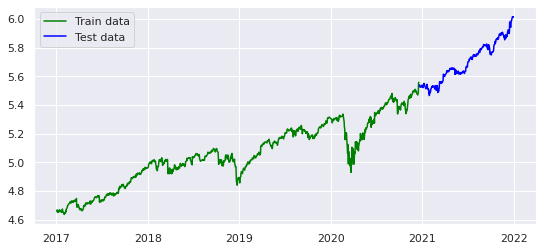

In [6]:
df.index.freq = 'B'
Ntest = 260  # business working days in a year

train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

plt.figure(figsize=(9, 4))
plt.plot(train['log_tr'], 'green', label='Train data')
plt.plot(test['log_tr'], 'blue', label='Test data')
plt.legend()
plt.show()

Estimating coefficients `p` and `q`:

In [7]:
# non-seasonal model
model = pm.auto_arima(train['log_tr'], seasonal=False,
                      d=1, start_p=0, start_q=0,
                 	  max_p=4, max_q=4,
                      information_criterion='aic',
                      trace=True, error_action='ignore',
                      stepwise=True,
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5358.152, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5411.026, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5403.897, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5357.214, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5411.573, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5410.338, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5408.558, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5410.729, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5407.852, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5409.348, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.396 seconds


In [8]:
# MAE (residuals)
mae = np.mean(np.abs(model.resid()))
print('MAE: %.3f' % mae)
print(model.summary())

MAE: 0.015
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:               SARIMAX(2, 1, 0)   Log Likelihood                2709.786
Date:                Mon, 24 Oct 2022   AIC                          -5411.573
Time:                        22:20:56   BIC                          -5391.950
Sample:                             0   HQIC                         -5404.114
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.001      1.933      0.053   -1.48e-05       0.002
ar.L1         -0.2195      0.018    -12.467      0.000      -0.254      -0.185
ar.L2          0.0510      0.015      3.4

Prob(Q) (Ljung–Box test) = 0.96 > 0.05.  The H0 that the residuals are uncorrelated cannot be rejected, so the `residuals are not correlated`.

Prob(JB) (Jarque–Bera test) = 0.00 < 0.05. The H0 that the residuals are normally distributed is rejected. The residuals are `not normally distributed`.

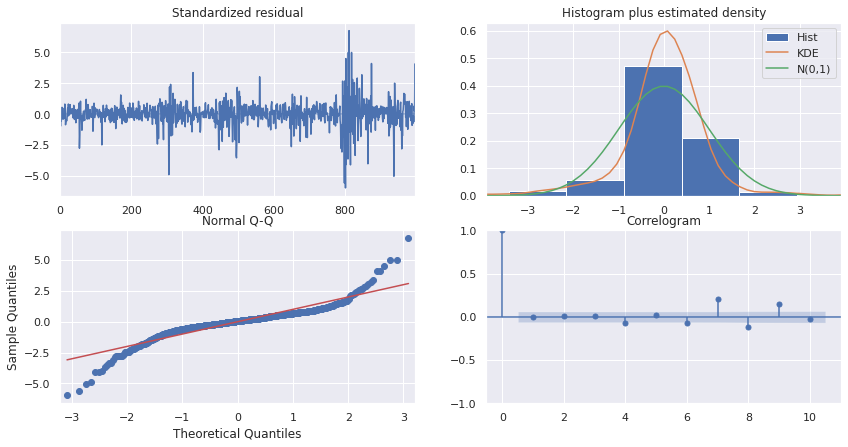

In [9]:
model.plot_diagnostics(figsize=(14, 7))
plt.show()

Analyzing the plots:

* *Standardized residual*: The residual errors fluctuate around a mean of zero.

* *Histogram plus kde estimate*: The orange curve is not similar to the green one of a normal distribution (for a good model the orange line should be similar to the green line).

* *Correlogram* or ACF plot: The residual errors are not autocorrelated, almost all of them are not significant (inside the blue area).

* *Normal Q-Q:* Most of the data points lie on the straight line, indicating a normal distribution of the residuals. Though, there's a number of outliers, not covered by the line.

In [10]:
train_preds = model.predict_in_sample(start=1, end=-1)  # d=1
test_preds, conf_interval = model.predict(n_periods=Ntest,
                                          return_conf_int=True)

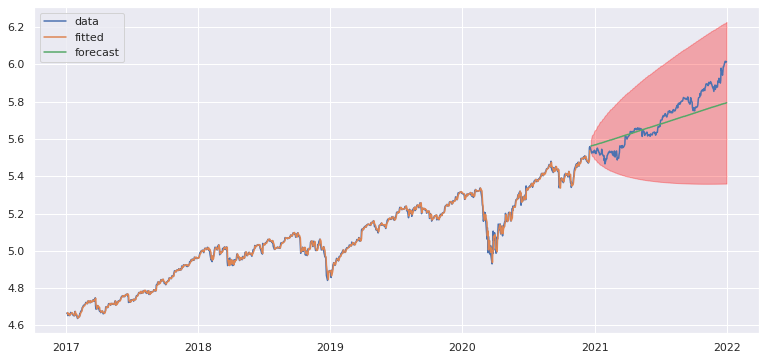

In [11]:
fig, ax = plt.subplots(figsize=(13, 6))

ax.plot(df.index, df['log_tr'], label='data')
ax.plot(train.index[1:], train_preds, label='fitted')
ax.plot(test.index, test_preds, label='forecast')
ax.fill_between(test.index, conf_interval[:, 0],
                conf_interval[:, 1], color='red', alpha=0.3)
ax.legend()
plt.show()

In [12]:
rmse = mean_squared_error(test['Close'], np.exp(test_preds), squared=False)
mape = mean_absolute_percentage_error(test['Close'].values, np.exp(test_preds.values))

print('RMSE: {}'.format(np.round(rmse, 2)))
print('MAPE: {}%'.format(np.round(mape, 2)))

RMSE: 26.06
MAPE: 6.27%


#### Prophet

In [13]:
from prophet import Prophet

In [14]:
df_p = pd.read_csv('data/accenture')

# Leave the format YYYY-MM-DD
df_p['Date'] = df_p.apply(lambda s: (s['Date'][:10]), axis=1)

df_close = df_p[["Date", "Close"]]
df_close['Date'] = pd.to_datetime(df_close['Date'])

In [15]:
# creating a specific format dataset
df_close.columns = ['ds', 'y']
df_close.tail(3)

,ds,y
1256,2021-12-29,409.828949
1257,2021-12-30,408.260315
1258,2021-12-31,408.970612


In [16]:
predictions = 260
train_df = df_close[:-predictions]

In [17]:
model_ph = Prophet().fit(train_df)

future = model_ph.make_future_dataframe(periods=predictions, freq='B')
future.tail(3)

22:20:58 - cmdstanpy - INFO - Chain [1] start processing
22:20:59 - cmdstanpy - INFO - Chain [1] done processing


,ds
1256,2021-12-15
1257,2021-12-16
1258,2021-12-17


In [18]:
forecast = model_ph.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
1256,2021-12-15,327.276561,231.852246,427.088439
1257,2021-12-16,327.537867,229.416818,427.193481
1258,2021-12-17,327.725642,229.770654,429.850694


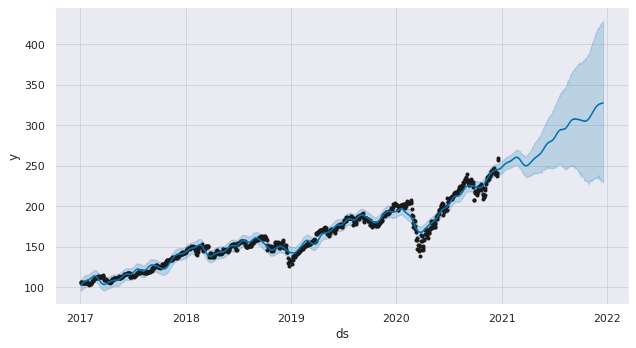

In [19]:
plot_forecast = model_ph.plot(forecast, figsize=(9, 5))

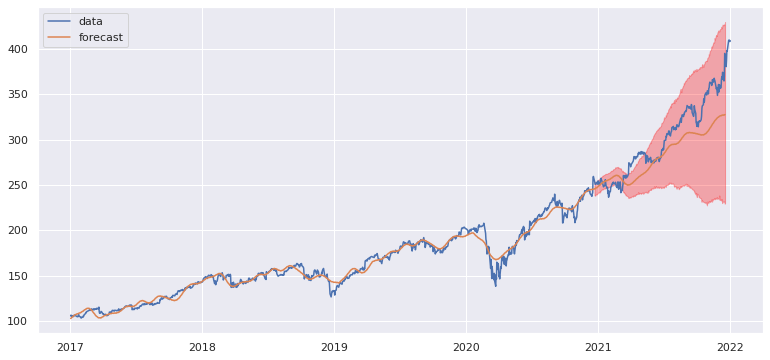

In [20]:
fig, ax = plt.subplots(figsize=(13, 6))

ax.plot(df_close.ds, df_close['y'], label='data')
ax.plot(forecast.ds, forecast['yhat'], label='forecast')
ax.fill_between(forecast.ds[-260:], forecast['yhat_lower'][-260:],
                forecast['yhat_upper'][-260:], color='red', alpha=0.3)
ax.legend()
plt.show()

In [21]:
y_test = df_close[-predictions:]['y']
y_pred = forecast[-predictions:]['yhat']

rmse_ph = mean_squared_error(y_test, y_pred, squared=False)
mape_ph = mean_absolute_percentage_error(y_test, y_pred)

print('RMSE: {}'.format(np.round(rmse_ph, 2)))
print('MAPE: {}%'.format(np.round(mape_ph, 2)))

RMSE: 28.67
MAPE: 6.97%


Both models give a reasonably good forecast. The ARIMA model clearly shows the price rise, while the prophet model makes a more accurate prediction. Since the last 2021 -2022 shows significant increase, the models are not able to reach these peaks based on the data from 2019-2021.